In [1]:
import sys
import torch
import math
import time
import importlib
import random
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from tensorboardX import SummaryWriter

from cis700.dataset import DBPediaDataset, count_lines
from cis700.tokenizer import build_tokenizer
from cis700 import utils

### Network Architecture

Here we develop the modules of our attention-based classifier. We had used the blog-post (https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec) as reference.

`WordEmbedding`: a simple wrapper around `nn.Embedding`

`PositionEncoding`: a module that implements the sinuoid position encoding described in "Attention is All You Need"

`MultiheadAttention`: a module that implmenets scale dot product attention

`FeedForward`: a simple 2-layer feedforward module with sparsity and dropout

`Normalization`: a module that implements batch normalization

`EncoderLayer`: a module that puts together self-attention and feedforward module to form a single layer of encoder

`Encoder`: a module that places N `EncoderLayers` one after another

`Classifier`: encoder plus linear layer

In [2]:
from cis700.model import *

### Some utility functions working with models

In [35]:
def initialize_model(model):
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
      
def save_model(model, name, epoch, step):
  filename = 'checkpoints/%s.epoch-%d.step-%d.pth' % (name, epoch, step)
  torch.save(model.state_dict(), filename)

def human_readable_prediction(text, model, max_seq_len, cat_id2text_fun):
  tok = build_tokenizer()
  tokens = tok.tokenize(text)
  ids = tok.convert_tokens_to_ids(tokens)
  if len(ids) > max_seq_len:
    ids = ids[0:max_seq_len]
  masks = [1] * len(ids)
  ids += [0] * (max_seq_len - len(ids))
  masks += [0] * (max_seq_len - len(masks))
  
  model.eval()
  ids = torch.Tensor(ids).type(torch.LongTensor).cuda().unsqueeze(0)
  masks = torch.Tensor(masks).cuda().unsqueeze(0)
  scores = model(ids, masks).squeeze()
  top_k = 5
  _, max_cat_ids = torch.topk(scores, k = top_k, dim = 0)
  top_cats = [cat_id2text_fun(int(max_cat_ids[i])) for i in range(top_k)]
  return top_cats

def swap_linear_layer(model, new_num_classes):
  model.fc = nn.Linear(model.dim_embedding * model.max_seq_len, new_num_classes)
  return model.cuda()

### Experiment 1 (Baseline on fine categories)

In [3]:
# configurations
max_seq_len        = 256
dim_embedding      = 50
num_heads          = 5
num_encoder_layers = 6
ff_num_features    = 1024
vocab_size         = count_lines('cis700/vocab/bert-base-uncased-vocab.txt')
batch_size         = 50

network_name = 'transformer-fine-s%d-e%d-h%d-l%d' % (max_seq_len, dim_embedding, num_heads, num_encoder_layers)

In [4]:
dbpedia_data = DBPediaDataset('/Users/hengchu/Downloads/cis700data/joinedlonabstract_en.nt', max_seq_len=max_seq_len)

100%|██████████| 1384619/1384619 [12:08<00:00, 1901.85it/s]


In [5]:
train_portion = 0.8
validation_portion = 0.1

train_size = int(len(dbpedia_data) * train_portion)
validation_size = int(len(dbpedia_data) * validation_portion)
test_size = len(dbpedia_data) - train_size - validation_size

train_set, validation_set, test_set = \
  torch.utils.data.random_split(dbpedia_data, [train_size, validation_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [6]:
# gather number of categories
num_fine_classes = dbpedia_data.num_fine_cats()
num_coarse_classes = dbpedia_data.num_coarse_cats()

In [8]:
device = torch.device('cuda:0')

model = Classifier(vocab_size, dim_embedding, num_heads,
                   ff_num_features, num_encoder_layers, 
                   max_seq_len, num_fine_classes)
initialize_model(model)
model = model.cuda()
optimizer = Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
loss_fun = nn.CrossEntropyLoss()
tb_writer = SummaryWriter('./logs')
epochs = 10

step  = 0
epoch = 0

for i in range(epochs):
  start_time = time.time()
  loss_val, validation_score, train_score = None, None, None
  for i_batch, batch_data in enumerate(train_loader):
    ids = batch_data[0].type(torch.LongTensor)
    masks = batch_data[1]
    fine_cats = batch_data[2]
    loss_val, train_score = utils.transformer_train(model, ids.cuda(), masks.cuda(), fine_cats.cuda(), loss_fun, optimizer)
    tb_writer.add_scalar('%s/loss_val' % network_name, loss_val, global_step=step)
    tb_writer.add_scalar('%s/train_acc' % network_name, train_score, global_step=step)
    step += 1
    if step % 5000 == 0:
      save_model(model, network_name, epoch, step)
  validation_score = utils.transformer_validate(model, validation_loader, 2, device)
  tb_writer.add_scalar('%s/validation_acc' % network_name, validation_score, global_step=step)
  end_time = time.time()
  epoch = i
  print('Epoch[%d] took %f seconds' % (epoch, end_time - start_time))
  print('train = %f, validation = %f, loss = %f' % (train_score, validation_score, loss_val))

Epoch[0] took 3039.741480 seconds
train = 0.266667, validation = 0.372993, loss = 2.936191
Epoch[1] took 3021.754335 seconds
train = 0.400000, validation = 0.402705, loss = 2.192239
Epoch[2] took 3022.240774 seconds
train = 0.488889, validation = 0.416861, loss = 2.177934
Epoch[3] took 3020.754504 seconds
train = 0.511111, validation = 0.430367, loss = 2.063056
Epoch[4] took 3020.989862 seconds
train = 0.488889, validation = 0.431053, loss = 2.216483
Epoch[5] took 3020.094303 seconds
train = 0.733333, validation = 0.433537, loss = 1.485769
Epoch[6] took 3020.544596 seconds
train = 0.600000, validation = 0.435661, loss = 1.564788
Epoch[7] took 3019.780324 seconds
train = 0.711111, validation = 0.434606, loss = 1.338268
Epoch[8] took 3019.645545 seconds
train = 0.733333, validation = 0.435083, loss = 1.493338
Epoch[9] took 3020.677503 seconds
train = 0.577778, validation = 0.432555, loss = 1.768355


In [9]:
save_model(model, network_name, epoch, step)

### Experiment 2 ((Baseline on f

In [12]:
# configurations
max_seq_len        = 256
dim_embedding      = 50
num_heads          = 5
num_encoder_layers = 6
ff_num_features    = 1024
vocab_size         = count_lines('cis700/vocab/bert-base-uncased-vocab.txt')
batch_size         = 50

network_name = 'transformer-coarse-2-s%d-e%d-h%d-l%d' % (max_seq_len, dim_embedding, num_heads, num_encoder_layers)

In [5]:
dbpedia_data = DBPediaDataset('/Users/hengchu/Downloads/cis700data/joinedlonabstract_en.nt', max_seq_len=max_seq_len)

100%|██████████| 1384619/1384619 [12:02<00:00, 1916.24it/s]


In [6]:
train_portion = 0.8
validation_portion = 0.1

train_size = int(len(dbpedia_data) * train_portion)
validation_size = int(len(dbpedia_data) * validation_portion)
test_size = len(dbpedia_data) - train_size - validation_size

train_set, validation_set, test_set = \
  torch.utils.data.random_split(dbpedia_data, [train_size, validation_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [7]:
# gather number of categories
num_fine_classes = dbpedia_data.num_fine_cats()
num_coarse_classes = dbpedia_data.num_coarse_cats()

In [13]:
device = torch.device('cuda:0')

model = Classifier(vocab_size, dim_embedding, num_heads,
                   ff_num_features, num_encoder_layers, 
                   max_seq_len, num_coarse_classes)
initialize_model(model)
model = model.cuda()
optimizer = Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
loss_fun = nn.CrossEntropyLoss()
tb_writer = SummaryWriter('./logs')
epochs = 10

step  = 0
epoch = 0

for i in range(epochs):
  start_time = time.time()
  loss_val, validation_score, train_score = None, None, None
  for i_batch, batch_data in enumerate(train_loader):
    ids = batch_data[0].type(torch.LongTensor)
    masks = batch_data[1]
    coarse_cats = batch_data[3]
    loss_val, train_score = utils.transformer_train(model, ids.cuda(), masks.cuda(), coarse_cats.cuda(), loss_fun, optimizer)
    tb_writer.add_scalar('%s/loss_val' % network_name, loss_val, global_step=step)
    tb_writer.add_scalar('%s/train_acc' % network_name, train_score, global_step=step)
    step += 1
    if step % 5000 == 0:
      save_model(model, network_name, epoch, step)
  validation_score = utils.transformer_validate(model, validation_loader, 3, device)
  tb_writer.add_scalar('%s/validation_acc' % network_name, validation_score, global_step=step)
  end_time = time.time()
  epoch = i
  print('Epoch[%d] took %f seconds' % (epoch, end_time - start_time))
  print('train = %f, validation = %f, loss = %f' % (train_score, validation_score, loss_val))

Epoch[0] took 2919.140594 seconds
train = 0.355556, validation = 0.382851, loss = 2.669782
Epoch[1] took 2914.652169 seconds
train = 0.488889, validation = 0.412867, loss = 2.143310
Epoch[2] took 2914.346581 seconds
train = 0.488889, validation = 0.425087, loss = 2.048670
Epoch[3] took 2912.895249 seconds
train = 0.466667, validation = 0.433349, loss = 1.624332
Epoch[4] took 2913.289681 seconds
train = 0.488889, validation = 0.439763, loss = 1.862073
Epoch[5] took 2915.485798 seconds
train = 0.466667, validation = 0.442630, loss = 1.840591
Epoch[6] took 2913.253220 seconds
train = 0.644444, validation = 0.443396, loss = 1.529210
Epoch[7] took 2908.874687 seconds
train = 0.644444, validation = 0.443338, loss = 1.066650
Epoch[8] took 2908.982422 seconds
train = 0.444444, validation = 0.443908, loss = 2.040223
Epoch[9] took 2909.085295 seconds
train = 0.577778, validation = 0.442226, loss = 1.453888


In [14]:
save_model(model, network_name, epoch, step)

### Bootstrap experiment

In [4]:
# configurations
max_seq_len        = 256
dim_embedding      = 50
num_heads          = 5
num_encoder_layers = 6
ff_num_features    = 1024
vocab_size         = count_lines('cis700/vocab/bert-base-uncased-vocab.txt')
batch_size         = 50

network_name = 'transformer-bootstrap2-s%d-e%d-h%d-l%d' % (max_seq_len, dim_embedding, num_heads, num_encoder_layers)

In [5]:
dbpedia_data = DBPediaDataset('/Users/hengchu/Downloads/cis700data/joinedlonabstract_en.nt', max_seq_len=max_seq_len)

100%|██████████| 1384619/1384619 [12:13<00:00, 1886.77it/s]


In [6]:
train_portion = 0.8
validation_portion = 0.1

train_size = int(len(dbpedia_data) * train_portion)
validation_size = int(len(dbpedia_data) * validation_portion)
test_size = len(dbpedia_data) - train_size - validation_size

train_set, validation_set, test_set = \
  torch.utils.data.random_split(dbpedia_data, [train_size, validation_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [6]:
# gather number of categories
num_fine_classes = dbpedia_data.num_fine_cats()
num_coarse_classes = dbpedia_data.num_coarse_cats()

NameError: name 'dbpedia_data' is not defined

In [8]:
device = torch.device('cuda:0')

model = Classifier(vocab_size, dim_embedding, num_heads,
                   ff_num_features, num_encoder_layers, 
                   max_seq_len, num_coarse_classes)
initialize_model(model)
model = model.cuda()
optimizer = Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
loss_fun = nn.CrossEntropyLoss()
tb_writer = SummaryWriter('./logs')
coarse_epochs = 2
fine_epochs = 10

step  = 0
epoch = 0

# train coarse_epochs on coarse labels
for i in range(coarse_epochs):
  start_time = time.time()
  loss_val, validation_score, train_score = None, None, None
  for i_batch, batch_data in enumerate(train_loader):
    ids = batch_data[0].type(torch.LongTensor)
    masks = batch_data[1]
    coarse_cats = batch_data[3]
    loss_val, train_score = utils.transformer_train(model, ids.cuda(), masks.cuda(), coarse_cats.cuda(), loss_fun, optimizer)
    tb_writer.add_scalar('%s/loss_val' % network_name, loss_val, global_step=step)
    tb_writer.add_scalar('%s/train_acc' % network_name, train_score, global_step=step)
    step += 1
    if step % 5000 == 0:
      save_model(model, network_name, epoch, step)
  validation_score = utils.transformer_validate(model, validation_loader, 3, device)
  tb_writer.add_scalar('%s/validation_acc' % network_name, validation_score, global_step=step)
  end_time = time.time()
  epoch = i
  print('Epoch[%d] took %f seconds' % (epoch, end_time - start_time))
  print('train = %f, validation = %f, loss = %f' % (train_score, validation_score, loss_val))
  
model = swap_linear_layer(model, num_fine_classes)

# then train fine_epochs on fine labels, compare accuracy increases to vanilla training on fine labels
for i in range(fine_epochs):
  start_time = time.time()
  loss_val, validation_score, train_score = None, None, None
  for i_batch, batch_data in enumerate(train_loader):
    ids = batch_data[0].type(torch.LongTensor)
    masks = batch_data[1]
    fine_cats = batch_data[2]
    loss_val, train_score = utils.transformer_train(model, ids.cuda(), masks.cuda(), fine_cats.cuda(), loss_fun, optimizer)
    tb_writer.add_scalar('%s/loss_val' % network_name, loss_val, global_step=step)
    tb_writer.add_scalar('%s/train_acc' % network_name, train_score, global_step=step)
    step += 1
    if step % 5000 == 0:
      save_model(model, network_name, epoch, step)
  validation_score = utils.transformer_validate(model, validation_loader, 2, device)
  tb_writer.add_scalar('%s/validation_acc' % network_name, validation_score, global_step=step)
  end_time = time.time()
  epoch = i
  print('Epoch[%d] took %f seconds' % (epoch, end_time - start_time))
  print('train = %f, validation = %f, loss = %f' % (train_score, validation_score, loss_val))

Epoch[0] took 3009.360830 seconds
train = 0.511111, validation = 0.386304, loss = 2.504602
Epoch[1] took 3004.730604 seconds
train = 0.288889, validation = 0.413633, loss = 2.671784
Epoch[0] took 3008.795308 seconds
train = 0.400000, validation = 0.393410, loss = 2.783735
Epoch[1] took 3007.895700 seconds
train = 0.422222, validation = 0.406815, loss = 2.259828
Epoch[2] took 3008.049983 seconds
train = 0.422222, validation = 0.420718, loss = 2.710992
Epoch[3] took 3006.731926 seconds
train = 0.377778, validation = 0.426106, loss = 2.422018
Epoch[4] took 3007.334610 seconds
train = 0.400000, validation = 0.429457, loss = 2.677648
Epoch[5] took 3006.229599 seconds
train = 0.400000, validation = 0.431089, loss = 2.263628
Epoch[6] took 3005.469187 seconds
train = 0.511111, validation = 0.434823, loss = 2.273735
Epoch[7] took 3005.929760 seconds
train = 0.533333, validation = 0.436267, loss = 2.120381
Epoch[8] took 3004.892882 seconds
train = 0.488889, validation = 0.436997, loss = 2.239928

In [9]:
save_model(model, network_name, epoch, step)

### Sanity check (please ignore)

In [9]:
try:
  if model:
    del model
except:
  pass

model = Classifier(vocab_size, dim_embedding, num_heads, ff_num_features, num_encoder_layers, max_seq_len, num_fine_classes)
model = model.cuda()
_, first_batch = next(enumerate(train_loader))
ids = first_batch[0].type(torch.LongTensor).cuda()
masks = first_batch[1].cuda()
r = model(ids, masks)
print(r)
print(r.size())
del model

RuntimeError: CUDA error: device-side assert triggered

### Scratch cells (please ignore)

In [9]:
importlib.reload(utils)

<module 'cis700.utils' from '/Users/hengchu/Documents/fun/cis700project/cis700/utils.py'>

In [12]:
del model

In [11]:
save_model(model, network_name, epoch, step)

In [10]:
utils.transformer_validate(model, validation_loader, 3, device)

KeyboardInterrupt: 

In [20]:
loss_val

tensor(2.0368, device='cuda:0', grad_fn=<NllLossBackward>)

In [21]:
validation_score

In [22]:
test_score

tensor(0.4496, device='cuda:0')

In [11]:
# find cases where the network guesses wrong

go = True
while go:
  idx = random.randint(0, len(dbpedia_data))
  features = dbpedia_data.get_feature(idx)
  top_cats = human_readable_prediction(dbpedia_data.get_feature(idx).text,
                                       model,
                                       max_seq_len,
                                       lambda id: dbpedia_data.fine_id2cat(id))
  if features.fine_cat_text in top_cats:
    continue

  print('>>> raw text')
  print(features.text)
  print('\n')
  print('>>> coarse cat:')
  print(features.coarse_cat_text)
  print('\n')
  print('>>> fine cat:')
  print(features.fine_cat_text)
  print('\n')
  print('>>> top predictions: ')
  for c in top_cats:
    print(c)
    
  break

>>> raw text
In fencing, an attack is the first offensive movement of a phrase.
>>> coarse cat:
<http://dbpedia.org/resource/Category:Behavior>
>>> fine cat:
<http://dbpedia.org/resource/Category:Conflict>
>>> top predictions: 
<http://dbpedia.org/resource/Category:Humans>
<http://dbpedia.org/resource/Category:Society>
<http://dbpedia.org/resource/Category:Government>
<http://dbpedia.org/resource/Category:Social_institutions>
<http://dbpedia.org/resource/Category:Politics>


In [17]:
  idx = random.randint(0, len(dbpedia_data))
  features = dbpedia_data.get_feature(idx)
  top_cats = human_readable_prediction(dbpedia_data.get_feature(idx).text,
                                       model,
                                       max_seq_len,
                                       lambda id: dbpedia_data.fine_id2cat(id))

  print('>>> raw text')
  print(features.text)
  print('')
  print('>>> coarse cat:')
  print(features.coarse_cat_text)
  print('')
  print('>>> fine cat:')
  print(features.fine_cat_text)
  print('')
  print('>>> top predictions: ')
  print('')
  for c in top_cats:
    print(c)


>>> raw text
In metadata, property equivalence is the statement that two properties have the same property extension or values. This usually (but not always) implies that the two properties have the same semantics or meaning. Technically it only implies that the data elements have the same values. Property equivalence is one of the three ways that a metadata registry can store equivalence mappings to other metadata registries. Note that property equivalence is not the same as property equality. Equivalent properties have the same \"values\", but may have different intensional meaning (i.e., denote different concepts). Property equality should be expressed with the owl:sameAs construct. As this requires that properties are treated as individuals, such axioms are only allowed in OWL Full.

>>> coarse cat:
<http://dbpedia.org/resource/Category:Technology>

>>> fine cat:
<http://dbpedia.org/resource/Category:Information_technology>

>>> top predictions: 

<http://dbpedia.org/resource/Categ

In [24]:
text = 'The mighty and terrible god of internet typos. The mysterious and all-knowing overlord of the Twitter trolls, and Pepe is his prophet. On this the 30th day of May, he was summoned by the orange king to begin his reign of terror over the lawless wasteland of cyberspace. And it shall be that no blogger, no profile, no Twitter egg shall know peace in the hereafter until they have bowed in reverence and fear at the glorious might of Covfefe.'
top_cats = human_readable_prediction(text,
                                     model,
                                     max_seq_len,
                                     lambda id: dbpedia_data.fine_id2cat(id))
print(text)
print('')
for c in top_cats:
  print(c)

The mighty and terrible god of internet typos. The mysterious and all-knowing overlord of the Twitter trolls, and Pepe is his prophet. On this the 30th day of May, he was summoned by the orange king to begin his reign of terror over the lawless wasteland of cyberspace. And it shall be that no blogger, no profile, no Twitter egg shall know peace in the hereafter until they have bowed in reverence and fear at the glorious might of Covfefe.

<http://dbpedia.org/resource/Category:Categories_for_renaming>
<http://dbpedia.org/resource/Category:Books_by_genre>
<http://dbpedia.org/resource/Category:Categories_by_year>
<http://dbpedia.org/resource/Category:Information>
<http://dbpedia.org/resource/Category:Literature>


In [90]:
dbpedia_data.get_feature(0)

{'text': "-30- (released as Deadline Midnight in the UK) is a 1959 movie starring William Conrad and Jack Webb as the editor and publisher, respectively, of a fictional Los Angeles evening newspaper. As the shift of a typical day starts, in which they don't know what will happen, the newspaper is created before our eyes as different stories are discovered and reported.", 'ids': [1011, 2382, 1011, 1006, 2207, 2004, 15117, 7090, 1999, 1996, 2866, 1007, 2003, 1037, 3851, 3185, 4626, 2520, 10931, 1998, 2990, 10923, 2004, 1996, 3559, 1998, 6674, 1010, 4414, 1010, 1997, 1037, 7214, 3050, 3349, 3944, 3780, 1012, 2004, 1996, 5670, 1997, 1037, 5171, 2154, 4627, 1010, 1999, 2029, 2027, 2123, 1005, 1056, 2113, 2054, 2097, 4148, 1010, 1996, 3780, 2003, 2580, 2077, 2256, 2159, 2004, 2367, 3441, 2024, 3603, 1998, 2988, 1012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [24]:
model.cuda()

RuntimeError: CUDA error: device-side assert triggered

In [31]:
torch.cuda.synchronize()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /Users/hengchu/Documents/work/pytorch/torch/csrc/cuda/Module.cpp:195

In [11]:
model.max_seq_len

256

In [12]:
nn.Linear(100, 10).cuda()

Linear(in_features=100, out_features=10, bias=True)

In [14]:
swap_linear_layer(model, num_coarse_classes)

Classifier(
  (encoder): Encoder(
    (embed): WordEmbedding(
      (embed): Embedding(30522, 50)
    )
    (pe): PositionEncoding()
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiheadAttention(
          (q_linear): Linear(in_features=50, out_features=50, bias=True)
          (v_linear): Linear(in_features=50, out_features=50, bias=True)
          (k_linear): Linear(in_features=50, out_features=50, bias=True)
          (dropout): Dropout(p=0.1)
          (out): Linear(in_features=50, out_features=50, bias=True)
        )
        (norm1): Normalization()
        (ff): FeedForward(
          (fc1): Linear(in_features=50, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1)
          (fc2): Linear(in_features=1024, out_features=50, bias=True)
        )
        (norm2): Normalization()
        (drop1): Dropout(p=0.1)
        (drop2): Dropout(p=0.1)
      )
      (1): EncoderLayer(
        (attention): MultiheadAttention(
          (q_line

In [7]:
model = Classifier(vocab_size, dim_embedding, num_heads,
                   ff_num_features, num_encoder_layers, 
                   max_seq_len, 370)
#model = model.cuda()

In [8]:
model.load_state_dict(torch.load('./checkpoints/transformer-bootstrap2-s256-e50-h5-l6.epoch-9.step-265848.pth'))

In [19]:
real_validation_labels = []
for _, batch in tqdm(enumerate(validation_loader), total=math.ceil(len(validation_set) / batch_size)):
  y = list(batch[2].numpy())
  real_validation_labels += y


100%|██████████| 2770/2770 [00:02<00:00, 1074.97it/s]

In [24]:
predicted_labels = []
model.eval()
with torch.no_grad():
  for _, batch in tqdm(enumerate(validation_loader), total=math.ceil(len(validation_set) / batch_size)):
    X = batch[0].type(torch.LongTensor)
    masks = batch[1]
    _, predicted = torch.max(model(X.cuda(), masks.cuda()), 1)
    predicted_labels += list(predicted.cpu().numpy())


 33%|███▎      | 906/2770 [00:32<01:07, 27.45it/s]


 65%|██████▍   | 1797/2770 [01:04<00:36, 26.79it/s]


 97%|█████████▋| 2685/2770 [01:37<00:03, 27.47it/s]


100%|██████████| 2770/2770 [01:40<00:00, 27.66it/s]

In [46]:
from sklearn.metrics import f1_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels
import numpy as np

In [27]:
f1_score(real_validation_labels, predicted_labels, average='micro')

0.520392023746759

In [29]:
f1_score(real_validation_labels, predicted_labels, average='weighted')

0.5094026441725386

In [31]:
confusion = confusion_matrix(real_validation_labels, predicted_labels)

In [32]:
confusion

array([[1004,    2,    2, ...,    0,    0,    0],
       [   2,  388,    0, ...,    0,    0,    0],
       [   0,    0,  504, ...,    0,    0,    0],
       ...,
       [   1,    0,    0, ...,   93,    9,    0],
       [   0,    0,    0, ...,    6,   45,    0],
       [   0,    0,    0, ...,    0,    0,  316]])

In [52]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.show()
    
    return ax


Confusion matrix, without normalization
[[1004    2    2 ...    0    0    0]
 [   2  388    0 ...    0    0    0]
 [   0    0  504 ...    0    0    0]
 ...
 [   1    0    0 ...   93    9    0]
 [   0    0    0 ...    6   45    0]
 [   0    0    0 ...    0    0  316]]


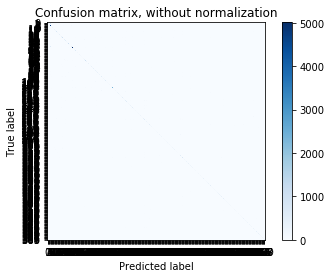

In [53]:
plot_confusion_matrix(real_validation_labels, predicted_labels)

In [50]:
plt.show()

In [41]:
unique_labels(real_validation_labels, predicted_labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [51]:
123

123

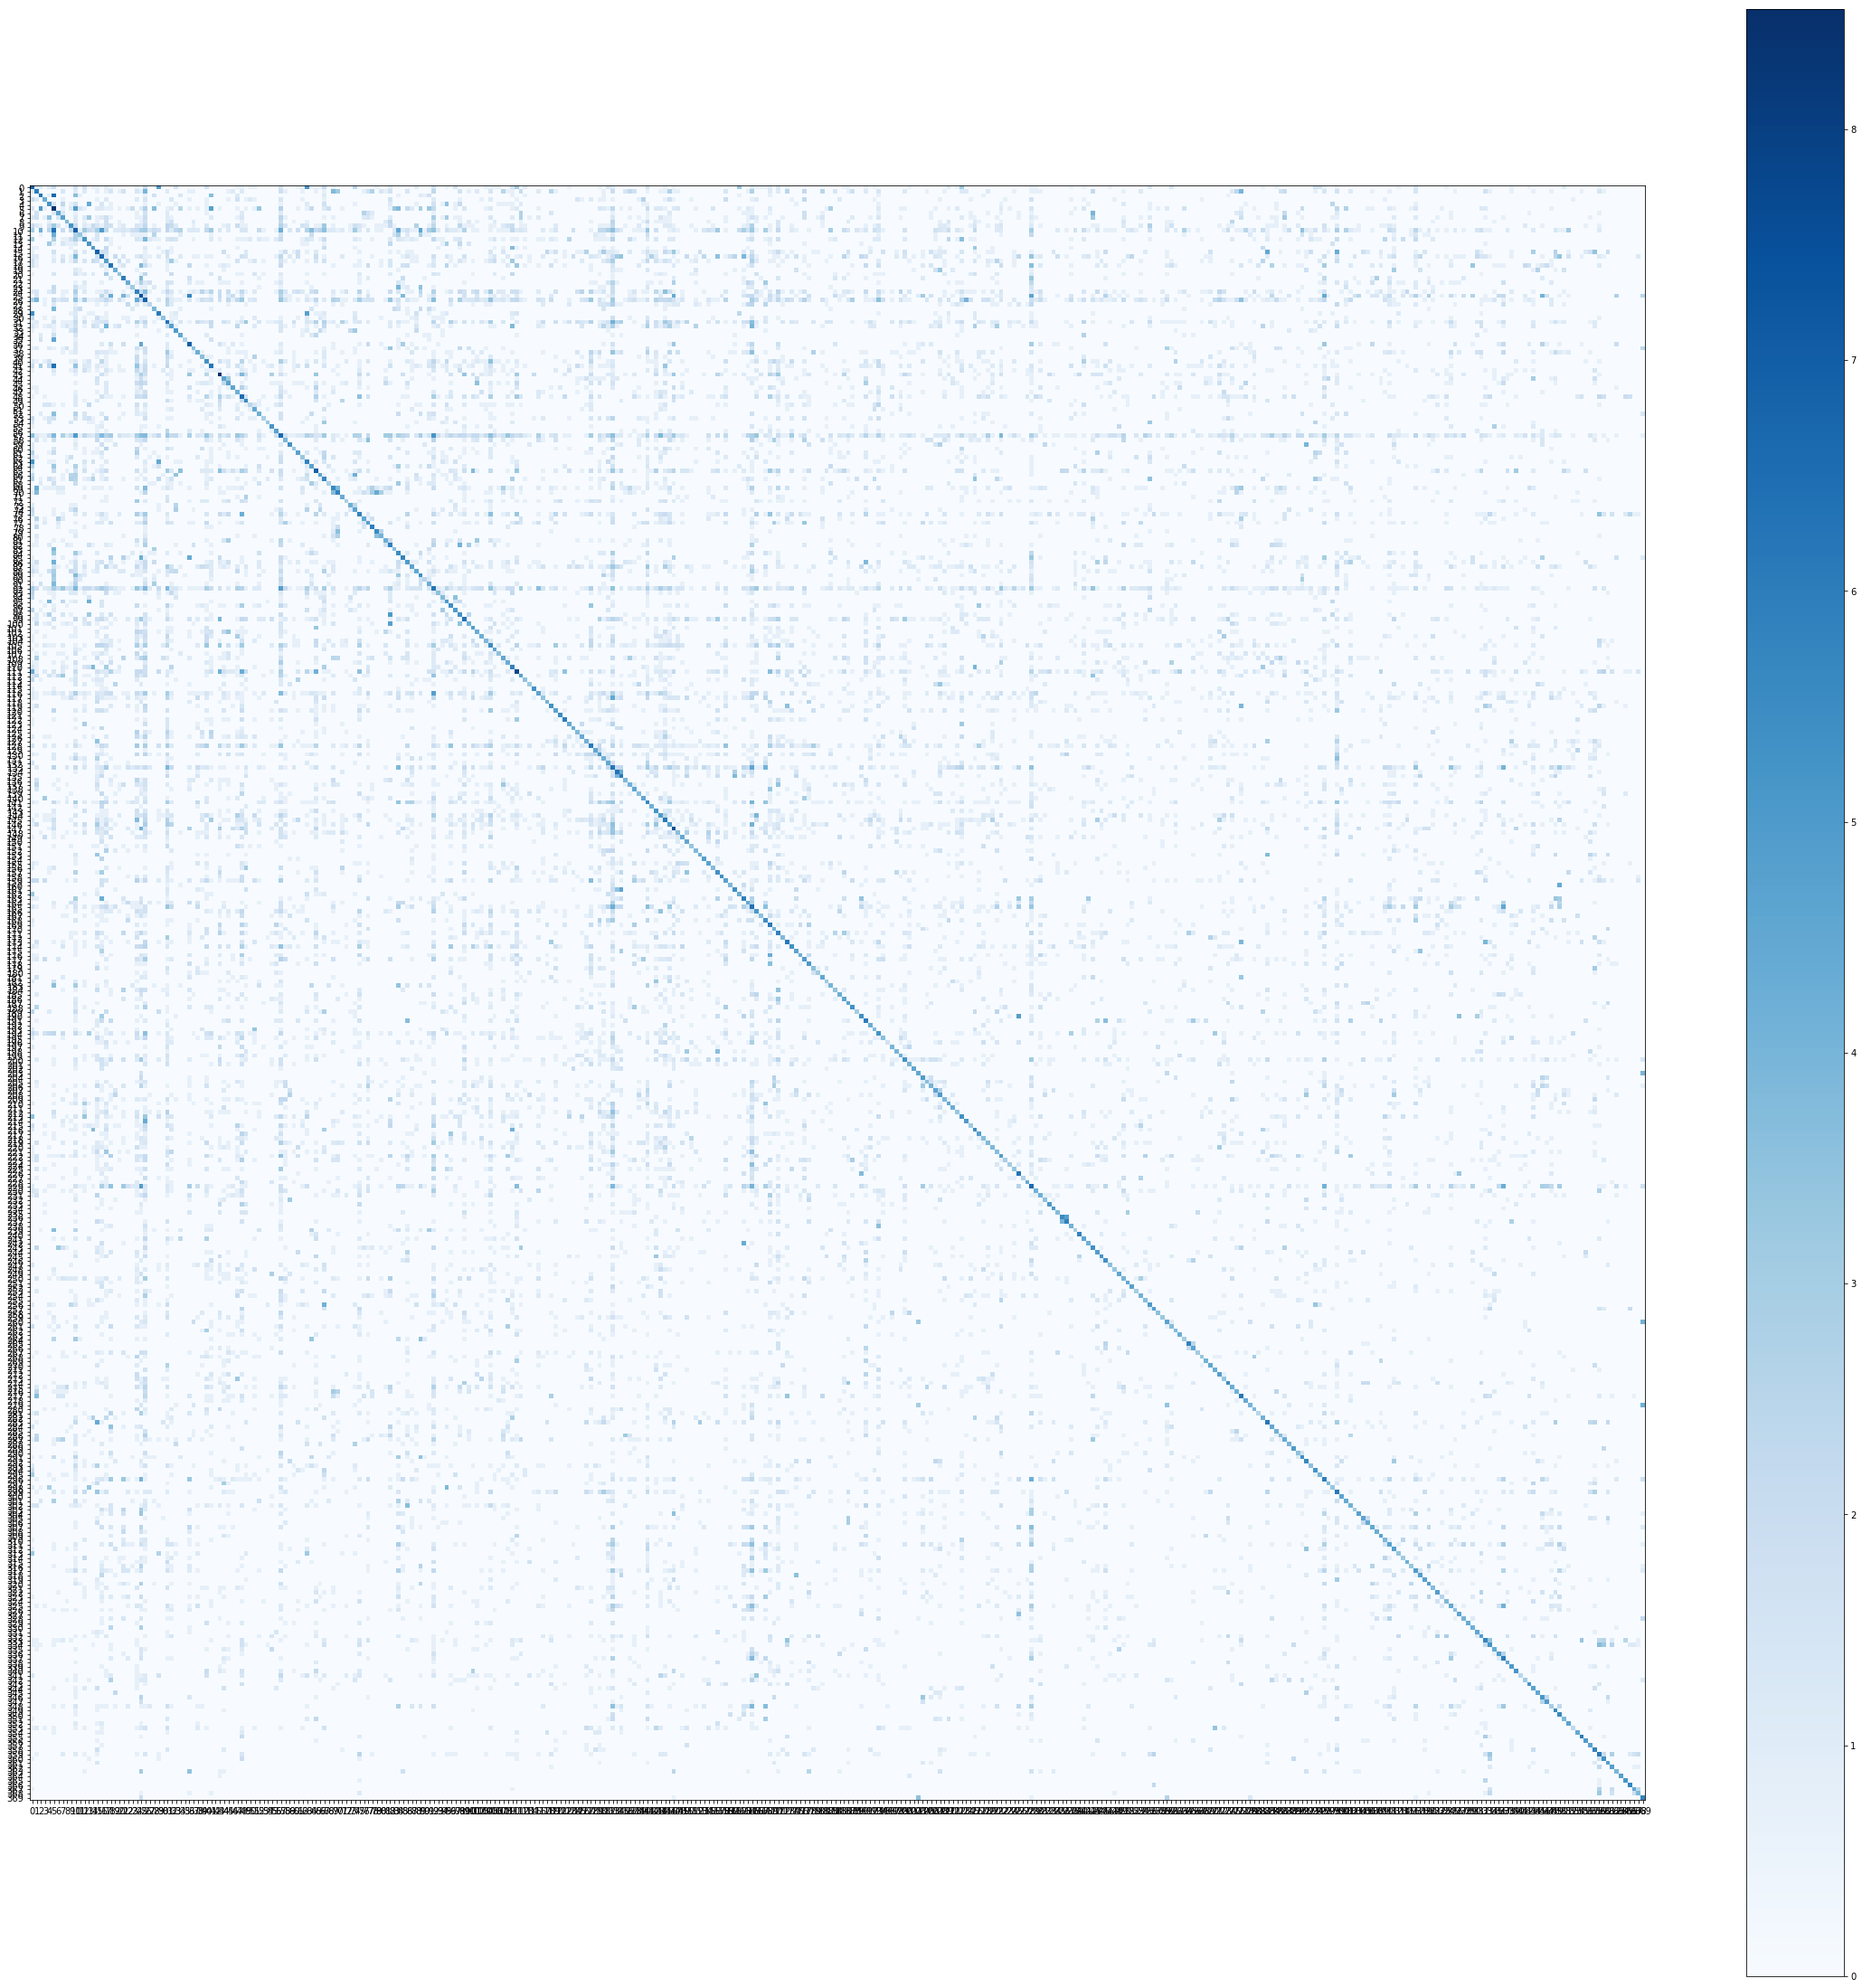

In [69]:
ticks = np.linspace(0, 369, num=370)
plt.figure(figsize=(40, 40))
plt.imshow(np.log(1 + np.array(confusion)), interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

In [60]:
np.linspace(0, 369, num=370)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [11]:
dir(dbpedia_data)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'coarse_cat_map',
 'coarse_id2cat',
 'data',
 'fine_cat_map',
 'fine_id2cat',
 'get_feature',
 'num_coarse_cats',
 'num_fine_cats',
 'reverse_coarse_cat_map',
 'reverse_fine_cat_map']

In [15]:
import json

In [17]:
json.dump(dbpedia_data.reverse_fine_cat_map, open('fine_categories.json', 'w'))

In [18]:
json.dump(dbpedia_data.reverse_coarse_cat_map, open('coarse_categories.json', 'w'))

In [19]:
dbpedia_data[0]

(tensor([ 1011.,  2382.,  1011.,  1006.,  2207.,  2004., 15117.,  7090.,  1999.,
          1996.,  2866.,  1007.,  2003.,  1037.,  3851.,  3185.,  4626.,  2520.,
         10931.,  1998.,  2990., 10923.,  2004.,  1996.,  3559.,  1998.,  6674.,
          1010.,  4414.,  1010.,  1997.,  1037.,  7214.,  3050.,  3349.,  3944.,
          3780.,  1012.,  2004.,  1996.,  5670.,  1997.,  1037.,  5171.,  2154.,
          4627.,  1010.,  1999.,  2029.,  2027.,  2123.,  1005.,  1056.,  2113.,
          2054.,  2097.,  4148.,  1010.,  1996.,  3780.,  2003.,  2580.,  2077.,
          2256.,  2159.,  2004.,  2367.,  3441.,  2024.,  3603.,  1998.,  2988.,
          1012.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,    

In [21]:
first_batch = next(enumerate(train_loader))

In [41]:
dummy_input = first_batch[1][0].type(torch.LongTensor)#.cuda()
dummy_mask = first_batch[1][1]#.cuda()
print(dummy_input)
print(dummy_mask)

tensor([[ 9932,  3211,  2003,  ...,     0,     0,     0],
        [ 1996, 28349, 10506,  ...,     0,     0,     0],
        [15634, 10147,  4691,  ...,     0,     0,     0],
        ...,
        [ 3165,  2697,  2003,  ...,     0,     0,     0],
        [ 4013, 16044,  2099,  ...,     0,     0,     0],
        [ 2148,  8166,  3545,  ...,     0,     0,     0]])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [42]:
torch.onnx.export(model, (dummy_input, dummy_mask), 'models/bootstrap2.onnx', verbose=True)

/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


RuntimeError: 
Schema not found for node. File a bug report.
Node: %scores.2 : Float(50, 5, 256, 256) = aten::masked_fill(%196, %195, %197), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]

Input types:Float(50, 5, 256, 256), Byte(50, 1, 1, 256), float
candidates were:
graph(%input.1 : Long(50, 256)
      %mask : Float(50, 256)
      %2 : Float(30522, 50)
      %3 : Float(1, 256, 50)
      %4 : Float(50, 50)
      %5 : Float(50)
      %6 : Float(50, 50)
      %7 : Float(50)
      %8 : Float(50, 50)
      %9 : Float(50)
      %10 : Float(50, 50)
      %11 : Float(50)
      %12 : Float(50)
      %13 : Float(50)
      %14 : Float(1024, 50)
      %15 : Float(1024)
      %16 : Float(50, 1024)
      %17 : Float(50)
      %18 : Float(50)
      %19 : Float(50)
      %20 : Float(50, 50)
      %21 : Float(50)
      %22 : Float(50, 50)
      %23 : Float(50)
      %24 : Float(50, 50)
      %25 : Float(50)
      %26 : Float(50, 50)
      %27 : Float(50)
      %28 : Float(50)
      %29 : Float(50)
      %30 : Float(1024, 50)
      %31 : Float(1024)
      %32 : Float(50, 1024)
      %33 : Float(50)
      %34 : Float(50)
      %35 : Float(50)
      %36 : Float(50, 50)
      %37 : Float(50)
      %38 : Float(50, 50)
      %39 : Float(50)
      %40 : Float(50, 50)
      %41 : Float(50)
      %42 : Float(50, 50)
      %43 : Float(50)
      %44 : Float(50)
      %45 : Float(50)
      %46 : Float(1024, 50)
      %47 : Float(1024)
      %48 : Float(50, 1024)
      %49 : Float(50)
      %50 : Float(50)
      %51 : Float(50)
      %52 : Float(50, 50)
      %53 : Float(50)
      %54 : Float(50, 50)
      %55 : Float(50)
      %56 : Float(50, 50)
      %57 : Float(50)
      %58 : Float(50, 50)
      %59 : Float(50)
      %60 : Float(50)
      %61 : Float(50)
      %62 : Float(1024, 50)
      %63 : Float(1024)
      %64 : Float(50, 1024)
      %65 : Float(50)
      %66 : Float(50)
      %67 : Float(50)
      %68 : Float(50, 50)
      %69 : Float(50)
      %70 : Float(50, 50)
      %71 : Float(50)
      %72 : Float(50, 50)
      %73 : Float(50)
      %74 : Float(50, 50)
      %75 : Float(50)
      %76 : Float(50)
      %77 : Float(50)
      %78 : Float(1024, 50)
      %79 : Float(1024)
      %80 : Float(50, 1024)
      %81 : Float(50)
      %82 : Float(50)
      %83 : Float(50)
      %84 : Float(50, 50)
      %85 : Float(50)
      %86 : Float(50, 50)
      %87 : Float(50)
      %88 : Float(50, 50)
      %89 : Float(50)
      %90 : Float(50, 50)
      %91 : Float(50)
      %92 : Float(50)
      %93 : Float(50)
      %94 : Float(1024, 50)
      %95 : Float(1024)
      %96 : Float(50, 1024)
      %97 : Float(50)
      %98 : Float(50)
      %99 : Float(50)
      %100 : Float(50)
      %101 : Float(50)
      %102 : Float(370, 12800)
      %103 : Float(370)) {
  %104 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/WordEmbedding[embed]/Embedding[embed]
  %105 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/WordEmbedding[embed]/Embedding[embed]
  %106 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/WordEmbedding[embed]/Embedding[embed]
  %107 : Float(50, 256, 50) = aten::embedding(%2, %input.1, %104, %105, %106), scope: Classifier/Encoder[encoder]/WordEmbedding[embed]/Embedding[embed]
  %108 : Double() = prim::Constant[value={7.07107}](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %109 : Float(50, 256, 50) = aten::mul(%107, %108), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %110 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %111 : int = aten::size(%109, %110), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %112 : Long() = prim::NumToTensor(%111), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %113 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %114 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %115 : int = prim::Constant[value=9223372036854775807](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %116 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %117 : Float(1, 256, 50) = aten::slice(%3, %113, %114, %115, %116), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %118 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %119 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %120 : int = prim::Constant[value=256](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %121 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %122 : Float(1, 256, 50) = aten::slice(%117, %118, %119, %120, %121), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %123 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %124 : Float(50, 256, 50) = aten::add(%109, %122, %123), scope: Classifier/Encoder[encoder]/PositionEncoding[pe]
  %125 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %126 : int[] = prim::ListConstruct(%125), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %127 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %128 : Float(50, 256, 1) = aten::mean(%124, %126, %127), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %129 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %130 : Float(50, 256, 50) = aten::sub(%124, %128, %129), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %131 : Float(50, 256, 50) = aten::mul(%12, %130), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %132 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %133 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %134 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %135 : Float(50, 256, 1) = aten::std(%124, %132, %133, %134), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %136 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %137 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %138 : Float(50, 256, 1) = aten::add(%135, %136, %137), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %139 : Float(50, 256, 50) = aten::div(%131, %138), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %140 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.2 : Float(50, 256, 50) = aten::add(%139, %13, %140), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %142 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %143 : int = aten::size(%input.2, %142), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %144 : Long() = prim::NumToTensor(%143), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %209 : int = prim::Int(%144), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %169 : int = prim::Int(%144), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %159 : int = prim::Int(%144), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %149 : int = prim::Int(%144), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %145 : Float(50!, 50!) = aten::t(%4), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %146 : Float(50, 256, 50) = aten::matmul(%input.2, %145), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %147 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %148 : Float(50, 256, 50) = aten::add(%146, %5, %147), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %150 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %151 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %152 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %153 : int[] = prim::ListConstruct(%149, %150, %151, %152), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %154 : Float(50, 256, 5, 10) = aten::view(%148, %153), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %155 : Float(50!, 50!) = aten::t(%6), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %156 : Float(50, 256, 50) = aten::matmul(%input.2, %155), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %157 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %158 : Float(50, 256, 50) = aten::add(%156, %7, %157), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %160 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %161 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %162 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %163 : int[] = prim::ListConstruct(%159, %160, %161, %162), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %164 : Float(50, 256, 5, 10) = aten::view(%158, %163), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %165 : Float(50!, 50!) = aten::t(%8), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %166 : Float(50, 256, 50) = aten::matmul(%input.2, %165), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %167 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %168 : Float(50, 256, 50) = aten::add(%166, %9, %167), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %170 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %171 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %172 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %173 : int[] = prim::ListConstruct(%169, %170, %171, %172), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %174 : Float(50, 256, 5, 10) = aten::view(%168, %173), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %175 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %176 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q.1 : Float(50!, 5!, 256!, 10) = aten::transpose(%154, %175, %176), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %178 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %179 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v.1 : Float(50!, 5!, 256!, 10) = aten::transpose(%164, %178, %179), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %181 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %182 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k.1 : Float(50!, 5!, 256!, 10) = aten::transpose(%174, %181, %182), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %184 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %185 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %186 : Float(50!, 5, 10!, 256!) = aten::transpose(%k.1, %184, %185), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %187 : Float(50, 5, 256, 256) = aten::matmul(%q.1, %186), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %188 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.1 : Float(50, 5, 256, 256) = aten::div(%187, %188), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %190 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %191 : Float(50, 1, 256) = aten::unsqueeze(%mask, %190), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %192 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %193 : Float(50, 1, 1, 256) = aten::unsqueeze(%191, %192), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %194 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %195 : Byte(50, 1, 1, 256) = aten::eq(%193, %194), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %196 : Float(50, 5, 256, 256) = aten::clone(%scores.1), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %197 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.2 : Float(50, 5, 256, 256) = aten::masked_fill(%196, %195, %197), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %199 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.3 : Float(50, 5, 256, 256) = aten::softmax(%scores.2, %199), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %201 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %202 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %203 : Float(50, 5, 256, 256) = aten::dropout(%input.3, %201, %202), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %204 : Float(50, 5, 256, 10) = aten::matmul(%203, %v.1), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %205 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %206 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %207 : Float(50!, 256!, 5!, 10) = aten::transpose(%204, %205, %206), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %208 : Float(50, 256, 5, 10) = aten::contiguous(%207), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %210 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %211 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %212 : int[] = prim::ListConstruct(%209, %210, %211), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.4 : Float(50, 256, 50) = aten::view(%208, %212), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %214 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %215 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %216 : Float(50, 256, 50) = aten::dropout(%input.4, %214, %215), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %217 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %218 : Float(50, 256, 50) = aten::add(%124, %216, %217), scope: Classifier/Encoder[encoder]/EncoderLayer
  %219 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %220 : int[] = prim::ListConstruct(%219), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %221 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %222 : Float(50, 256, 1) = aten::mean(%218, %220, %221), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %223 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %224 : Float(50, 256, 50) = aten::sub(%218, %222, %223), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %225 : Float(50, 256, 50) = aten::mul(%18, %224), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %226 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %227 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %228 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %229 : Float(50, 256, 1) = aten::std(%218, %226, %227, %228), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %230 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %231 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %232 : Float(50, 256, 1) = aten::add(%229, %230, %231), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %233 : Float(50, 256, 50) = aten::div(%225, %232), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %234 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.5 : Float(50, 256, 50) = aten::add(%233, %19, %234), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %236 : Float(50!, 1024!) = aten::t(%14), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %237 : Float(50, 256, 1024) = aten::matmul(%input.5, %236), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %238 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x.1 : Float(50, 256, 1024) = aten::add(%237, %15, %238), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.6 : Float(50, 256, 1024) = aten::relu(%x.1), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %241 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %242 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.7 : Float(50, 256, 1024) = aten::dropout(%input.6, %241, %242), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %244 : Float(1024!, 50!) = aten::t(%16), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %245 : Float(50, 256, 50) = aten::matmul(%input.7, %244), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %246 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.8 : Float(50, 256, 50) = aten::add(%245, %17, %246), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %248 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %249 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %250 : Float(50, 256, 50) = aten::dropout(%input.8, %248, %249), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %251 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %252 : Float(50, 256, 50) = aten::add(%218, %250, %251), scope: Classifier/Encoder[encoder]/EncoderLayer
  %253 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %254 : int[] = prim::ListConstruct(%253), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %255 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %256 : Float(50, 256, 1) = aten::mean(%252, %254, %255), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %257 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %258 : Float(50, 256, 50) = aten::sub(%252, %256, %257), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %259 : Float(50, 256, 50) = aten::mul(%28, %258), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %260 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %261 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %262 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %263 : Float(50, 256, 1) = aten::std(%252, %260, %261, %262), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %264 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %265 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %266 : Float(50, 256, 1) = aten::add(%263, %264, %265), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %267 : Float(50, 256, 50) = aten::div(%259, %266), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %268 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.9 : Float(50, 256, 50) = aten::add(%267, %29, %268), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %270 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %271 : int = aten::size(%input.9, %270), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %272 : Long() = prim::NumToTensor(%271), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %337 : int = prim::Int(%272), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %297 : int = prim::Int(%272), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %287 : int = prim::Int(%272), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %277 : int = prim::Int(%272), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %273 : Float(50!, 50!) = aten::t(%20), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %274 : Float(50, 256, 50) = aten::matmul(%input.9, %273), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %275 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %276 : Float(50, 256, 50) = aten::add(%274, %21, %275), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %278 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %279 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %280 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %281 : int[] = prim::ListConstruct(%277, %278, %279, %280), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %282 : Float(50, 256, 5, 10) = aten::view(%276, %281), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %283 : Float(50!, 50!) = aten::t(%22), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %284 : Float(50, 256, 50) = aten::matmul(%input.9, %283), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %285 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %286 : Float(50, 256, 50) = aten::add(%284, %23, %285), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %288 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %289 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %290 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %291 : int[] = prim::ListConstruct(%287, %288, %289, %290), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %292 : Float(50, 256, 5, 10) = aten::view(%286, %291), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %293 : Float(50!, 50!) = aten::t(%24), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %294 : Float(50, 256, 50) = aten::matmul(%input.9, %293), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %295 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %296 : Float(50, 256, 50) = aten::add(%294, %25, %295), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %298 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %299 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %300 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %301 : int[] = prim::ListConstruct(%297, %298, %299, %300), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %302 : Float(50, 256, 5, 10) = aten::view(%296, %301), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %303 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %304 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q.2 : Float(50!, 5!, 256!, 10) = aten::transpose(%282, %303, %304), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %306 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %307 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v.2 : Float(50!, 5!, 256!, 10) = aten::transpose(%292, %306, %307), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %309 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %310 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k.2 : Float(50!, 5!, 256!, 10) = aten::transpose(%302, %309, %310), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %312 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %313 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %314 : Float(50!, 5, 10!, 256!) = aten::transpose(%k.2, %312, %313), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %315 : Float(50, 5, 256, 256) = aten::matmul(%q.2, %314), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %316 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.3 : Float(50, 5, 256, 256) = aten::div(%315, %316), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %318 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %319 : Float(50, 1, 256) = aten::unsqueeze(%mask, %318), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %320 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %321 : Float(50, 1, 1, 256) = aten::unsqueeze(%319, %320), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %322 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %323 : Byte(50, 1, 1, 256) = aten::eq(%321, %322), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %324 : Float(50, 5, 256, 256) = aten::clone(%scores.3), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %325 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.4 : Float(50, 5, 256, 256) = aten::masked_fill(%324, %323, %325), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %327 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.10 : Float(50, 5, 256, 256) = aten::softmax(%scores.4, %327), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %329 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %330 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %331 : Float(50, 5, 256, 256) = aten::dropout(%input.10, %329, %330), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %332 : Float(50, 5, 256, 10) = aten::matmul(%331, %v.2), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %333 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %334 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %335 : Float(50!, 256!, 5!, 10) = aten::transpose(%332, %333, %334), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %336 : Float(50, 256, 5, 10) = aten::contiguous(%335), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %338 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %339 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %340 : int[] = prim::ListConstruct(%337, %338, %339), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.11 : Float(50, 256, 50) = aten::view(%336, %340), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %342 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %343 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %344 : Float(50, 256, 50) = aten::dropout(%input.11, %342, %343), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %345 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %346 : Float(50, 256, 50) = aten::add(%252, %344, %345), scope: Classifier/Encoder[encoder]/EncoderLayer
  %347 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %348 : int[] = prim::ListConstruct(%347), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %349 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %350 : Float(50, 256, 1) = aten::mean(%346, %348, %349), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %351 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %352 : Float(50, 256, 50) = aten::sub(%346, %350, %351), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %353 : Float(50, 256, 50) = aten::mul(%34, %352), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %354 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %355 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %356 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %357 : Float(50, 256, 1) = aten::std(%346, %354, %355, %356), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %358 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %359 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %360 : Float(50, 256, 1) = aten::add(%357, %358, %359), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %361 : Float(50, 256, 50) = aten::div(%353, %360), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %362 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.12 : Float(50, 256, 50) = aten::add(%361, %35, %362), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %364 : Float(50!, 1024!) = aten::t(%30), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %365 : Float(50, 256, 1024) = aten::matmul(%input.12, %364), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %366 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x.2 : Float(50, 256, 1024) = aten::add(%365, %31, %366), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.13 : Float(50, 256, 1024) = aten::relu(%x.2), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %369 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %370 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.14 : Float(50, 256, 1024) = aten::dropout(%input.13, %369, %370), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %372 : Float(1024!, 50!) = aten::t(%32), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %373 : Float(50, 256, 50) = aten::matmul(%input.14, %372), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %374 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.15 : Float(50, 256, 50) = aten::add(%373, %33, %374), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %376 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %377 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %378 : Float(50, 256, 50) = aten::dropout(%input.15, %376, %377), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %379 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %380 : Float(50, 256, 50) = aten::add(%346, %378, %379), scope: Classifier/Encoder[encoder]/EncoderLayer
  %381 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %382 : int[] = prim::ListConstruct(%381), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %383 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %384 : Float(50, 256, 1) = aten::mean(%380, %382, %383), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %385 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %386 : Float(50, 256, 50) = aten::sub(%380, %384, %385), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %387 : Float(50, 256, 50) = aten::mul(%44, %386), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %388 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %389 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %390 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %391 : Float(50, 256, 1) = aten::std(%380, %388, %389, %390), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %392 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %393 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %394 : Float(50, 256, 1) = aten::add(%391, %392, %393), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %395 : Float(50, 256, 50) = aten::div(%387, %394), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %396 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.16 : Float(50, 256, 50) = aten::add(%395, %45, %396), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %398 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %399 : int = aten::size(%input.16, %398), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %400 : Long() = prim::NumToTensor(%399), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %465 : int = prim::Int(%400), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %425 : int = prim::Int(%400), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %415 : int = prim::Int(%400), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %405 : int = prim::Int(%400), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %401 : Float(50!, 50!) = aten::t(%36), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %402 : Float(50, 256, 50) = aten::matmul(%input.16, %401), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %403 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %404 : Float(50, 256, 50) = aten::add(%402, %37, %403), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %406 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %407 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %408 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %409 : int[] = prim::ListConstruct(%405, %406, %407, %408), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %410 : Float(50, 256, 5, 10) = aten::view(%404, %409), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %411 : Float(50!, 50!) = aten::t(%38), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %412 : Float(50, 256, 50) = aten::matmul(%input.16, %411), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %413 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %414 : Float(50, 256, 50) = aten::add(%412, %39, %413), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %416 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %417 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %418 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %419 : int[] = prim::ListConstruct(%415, %416, %417, %418), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %420 : Float(50, 256, 5, 10) = aten::view(%414, %419), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %421 : Float(50!, 50!) = aten::t(%40), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %422 : Float(50, 256, 50) = aten::matmul(%input.16, %421), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %423 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %424 : Float(50, 256, 50) = aten::add(%422, %41, %423), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %426 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %427 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %428 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %429 : int[] = prim::ListConstruct(%425, %426, %427, %428), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %430 : Float(50, 256, 5, 10) = aten::view(%424, %429), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %431 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %432 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q.3 : Float(50!, 5!, 256!, 10) = aten::transpose(%410, %431, %432), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %434 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %435 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v.3 : Float(50!, 5!, 256!, 10) = aten::transpose(%420, %434, %435), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %437 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %438 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k.3 : Float(50!, 5!, 256!, 10) = aten::transpose(%430, %437, %438), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %440 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %441 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %442 : Float(50!, 5, 10!, 256!) = aten::transpose(%k.3, %440, %441), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %443 : Float(50, 5, 256, 256) = aten::matmul(%q.3, %442), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %444 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.5 : Float(50, 5, 256, 256) = aten::div(%443, %444), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %446 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %447 : Float(50, 1, 256) = aten::unsqueeze(%mask, %446), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %448 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %449 : Float(50, 1, 1, 256) = aten::unsqueeze(%447, %448), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %450 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %451 : Byte(50, 1, 1, 256) = aten::eq(%449, %450), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %452 : Float(50, 5, 256, 256) = aten::clone(%scores.5), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %453 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.6 : Float(50, 5, 256, 256) = aten::masked_fill(%452, %451, %453), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %455 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.17 : Float(50, 5, 256, 256) = aten::softmax(%scores.6, %455), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %457 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %458 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %459 : Float(50, 5, 256, 256) = aten::dropout(%input.17, %457, %458), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %460 : Float(50, 5, 256, 10) = aten::matmul(%459, %v.3), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %461 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %462 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %463 : Float(50!, 256!, 5!, 10) = aten::transpose(%460, %461, %462), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %464 : Float(50, 256, 5, 10) = aten::contiguous(%463), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %466 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %467 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %468 : int[] = prim::ListConstruct(%465, %466, %467), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.18 : Float(50, 256, 50) = aten::view(%464, %468), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %470 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %471 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %472 : Float(50, 256, 50) = aten::dropout(%input.18, %470, %471), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %473 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %474 : Float(50, 256, 50) = aten::add(%380, %472, %473), scope: Classifier/Encoder[encoder]/EncoderLayer
  %475 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %476 : int[] = prim::ListConstruct(%475), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %477 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %478 : Float(50, 256, 1) = aten::mean(%474, %476, %477), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %479 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %480 : Float(50, 256, 50) = aten::sub(%474, %478, %479), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %481 : Float(50, 256, 50) = aten::mul(%50, %480), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %482 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %483 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %484 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %485 : Float(50, 256, 1) = aten::std(%474, %482, %483, %484), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %486 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %487 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %488 : Float(50, 256, 1) = aten::add(%485, %486, %487), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %489 : Float(50, 256, 50) = aten::div(%481, %488), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %490 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.19 : Float(50, 256, 50) = aten::add(%489, %51, %490), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %492 : Float(50!, 1024!) = aten::t(%46), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %493 : Float(50, 256, 1024) = aten::matmul(%input.19, %492), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %494 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x.3 : Float(50, 256, 1024) = aten::add(%493, %47, %494), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.20 : Float(50, 256, 1024) = aten::relu(%x.3), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %497 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %498 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.21 : Float(50, 256, 1024) = aten::dropout(%input.20, %497, %498), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %500 : Float(1024!, 50!) = aten::t(%48), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %501 : Float(50, 256, 50) = aten::matmul(%input.21, %500), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %502 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.22 : Float(50, 256, 50) = aten::add(%501, %49, %502), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %504 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %505 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %506 : Float(50, 256, 50) = aten::dropout(%input.22, %504, %505), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %507 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %508 : Float(50, 256, 50) = aten::add(%474, %506, %507), scope: Classifier/Encoder[encoder]/EncoderLayer
  %509 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %510 : int[] = prim::ListConstruct(%509), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %511 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %512 : Float(50, 256, 1) = aten::mean(%508, %510, %511), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %513 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %514 : Float(50, 256, 50) = aten::sub(%508, %512, %513), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %515 : Float(50, 256, 50) = aten::mul(%60, %514), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %516 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %517 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %518 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %519 : Float(50, 256, 1) = aten::std(%508, %516, %517, %518), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %520 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %521 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %522 : Float(50, 256, 1) = aten::add(%519, %520, %521), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %523 : Float(50, 256, 50) = aten::div(%515, %522), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %524 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.23 : Float(50, 256, 50) = aten::add(%523, %61, %524), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %526 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %527 : int = aten::size(%input.23, %526), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %528 : Long() = prim::NumToTensor(%527), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %593 : int = prim::Int(%528), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %553 : int = prim::Int(%528), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %543 : int = prim::Int(%528), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %533 : int = prim::Int(%528), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %529 : Float(50!, 50!) = aten::t(%52), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %530 : Float(50, 256, 50) = aten::matmul(%input.23, %529), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %531 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %532 : Float(50, 256, 50) = aten::add(%530, %53, %531), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %534 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %535 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %536 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %537 : int[] = prim::ListConstruct(%533, %534, %535, %536), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %538 : Float(50, 256, 5, 10) = aten::view(%532, %537), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %539 : Float(50!, 50!) = aten::t(%54), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %540 : Float(50, 256, 50) = aten::matmul(%input.23, %539), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %541 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %542 : Float(50, 256, 50) = aten::add(%540, %55, %541), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %544 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %545 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %546 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %547 : int[] = prim::ListConstruct(%543, %544, %545, %546), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %548 : Float(50, 256, 5, 10) = aten::view(%542, %547), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %549 : Float(50!, 50!) = aten::t(%56), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %550 : Float(50, 256, 50) = aten::matmul(%input.23, %549), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %551 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %552 : Float(50, 256, 50) = aten::add(%550, %57, %551), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %554 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %555 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %556 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %557 : int[] = prim::ListConstruct(%553, %554, %555, %556), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %558 : Float(50, 256, 5, 10) = aten::view(%552, %557), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %559 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %560 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q.4 : Float(50!, 5!, 256!, 10) = aten::transpose(%538, %559, %560), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %562 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %563 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v.4 : Float(50!, 5!, 256!, 10) = aten::transpose(%548, %562, %563), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %565 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %566 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k.4 : Float(50!, 5!, 256!, 10) = aten::transpose(%558, %565, %566), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %568 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %569 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %570 : Float(50!, 5, 10!, 256!) = aten::transpose(%k.4, %568, %569), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %571 : Float(50, 5, 256, 256) = aten::matmul(%q.4, %570), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %572 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.7 : Float(50, 5, 256, 256) = aten::div(%571, %572), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %574 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %575 : Float(50, 1, 256) = aten::unsqueeze(%mask, %574), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %576 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %577 : Float(50, 1, 1, 256) = aten::unsqueeze(%575, %576), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %578 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %579 : Byte(50, 1, 1, 256) = aten::eq(%577, %578), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %580 : Float(50, 5, 256, 256) = aten::clone(%scores.7), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %581 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.8 : Float(50, 5, 256, 256) = aten::masked_fill(%580, %579, %581), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %583 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.24 : Float(50, 5, 256, 256) = aten::softmax(%scores.8, %583), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %585 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %586 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %587 : Float(50, 5, 256, 256) = aten::dropout(%input.24, %585, %586), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %588 : Float(50, 5, 256, 10) = aten::matmul(%587, %v.4), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %589 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %590 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %591 : Float(50!, 256!, 5!, 10) = aten::transpose(%588, %589, %590), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %592 : Float(50, 256, 5, 10) = aten::contiguous(%591), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %594 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %595 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %596 : int[] = prim::ListConstruct(%593, %594, %595), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.25 : Float(50, 256, 50) = aten::view(%592, %596), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %598 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %599 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %600 : Float(50, 256, 50) = aten::dropout(%input.25, %598, %599), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %601 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %602 : Float(50, 256, 50) = aten::add(%508, %600, %601), scope: Classifier/Encoder[encoder]/EncoderLayer
  %603 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %604 : int[] = prim::ListConstruct(%603), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %605 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %606 : Float(50, 256, 1) = aten::mean(%602, %604, %605), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %607 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %608 : Float(50, 256, 50) = aten::sub(%602, %606, %607), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %609 : Float(50, 256, 50) = aten::mul(%66, %608), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %610 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %611 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %612 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %613 : Float(50, 256, 1) = aten::std(%602, %610, %611, %612), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %614 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %615 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %616 : Float(50, 256, 1) = aten::add(%613, %614, %615), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %617 : Float(50, 256, 50) = aten::div(%609, %616), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %618 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.26 : Float(50, 256, 50) = aten::add(%617, %67, %618), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %620 : Float(50!, 1024!) = aten::t(%62), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %621 : Float(50, 256, 1024) = aten::matmul(%input.26, %620), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %622 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x.4 : Float(50, 256, 1024) = aten::add(%621, %63, %622), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.27 : Float(50, 256, 1024) = aten::relu(%x.4), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %625 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %626 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.28 : Float(50, 256, 1024) = aten::dropout(%input.27, %625, %626), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %628 : Float(1024!, 50!) = aten::t(%64), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %629 : Float(50, 256, 50) = aten::matmul(%input.28, %628), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %630 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.29 : Float(50, 256, 50) = aten::add(%629, %65, %630), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %632 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %633 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %634 : Float(50, 256, 50) = aten::dropout(%input.29, %632, %633), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %635 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %636 : Float(50, 256, 50) = aten::add(%602, %634, %635), scope: Classifier/Encoder[encoder]/EncoderLayer
  %637 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %638 : int[] = prim::ListConstruct(%637), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %639 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %640 : Float(50, 256, 1) = aten::mean(%636, %638, %639), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %641 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %642 : Float(50, 256, 50) = aten::sub(%636, %640, %641), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %643 : Float(50, 256, 50) = aten::mul(%76, %642), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %644 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %645 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %646 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %647 : Float(50, 256, 1) = aten::std(%636, %644, %645, %646), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %648 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %649 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %650 : Float(50, 256, 1) = aten::add(%647, %648, %649), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %651 : Float(50, 256, 50) = aten::div(%643, %650), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %652 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.30 : Float(50, 256, 50) = aten::add(%651, %77, %652), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %654 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %655 : int = aten::size(%input.30, %654), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %656 : Long() = prim::NumToTensor(%655), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %721 : int = prim::Int(%656), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %681 : int = prim::Int(%656), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %671 : int = prim::Int(%656), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %661 : int = prim::Int(%656), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %657 : Float(50!, 50!) = aten::t(%68), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %658 : Float(50, 256, 50) = aten::matmul(%input.30, %657), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %659 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %660 : Float(50, 256, 50) = aten::add(%658, %69, %659), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %662 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %663 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %664 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %665 : int[] = prim::ListConstruct(%661, %662, %663, %664), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %666 : Float(50, 256, 5, 10) = aten::view(%660, %665), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %667 : Float(50!, 50!) = aten::t(%70), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %668 : Float(50, 256, 50) = aten::matmul(%input.30, %667), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %669 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %670 : Float(50, 256, 50) = aten::add(%668, %71, %669), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %672 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %673 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %674 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %675 : int[] = prim::ListConstruct(%671, %672, %673, %674), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %676 : Float(50, 256, 5, 10) = aten::view(%670, %675), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %677 : Float(50!, 50!) = aten::t(%72), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %678 : Float(50, 256, 50) = aten::matmul(%input.30, %677), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %679 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %680 : Float(50, 256, 50) = aten::add(%678, %73, %679), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %682 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %683 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %684 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %685 : int[] = prim::ListConstruct(%681, %682, %683, %684), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %686 : Float(50, 256, 5, 10) = aten::view(%680, %685), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %687 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %688 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q.5 : Float(50!, 5!, 256!, 10) = aten::transpose(%666, %687, %688), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %690 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %691 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v.5 : Float(50!, 5!, 256!, 10) = aten::transpose(%676, %690, %691), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %693 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %694 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k.5 : Float(50!, 5!, 256!, 10) = aten::transpose(%686, %693, %694), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %696 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %697 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %698 : Float(50!, 5, 10!, 256!) = aten::transpose(%k.5, %696, %697), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %699 : Float(50, 5, 256, 256) = aten::matmul(%q.5, %698), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %700 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.9 : Float(50, 5, 256, 256) = aten::div(%699, %700), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %702 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %703 : Float(50, 1, 256) = aten::unsqueeze(%mask, %702), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %704 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %705 : Float(50, 1, 1, 256) = aten::unsqueeze(%703, %704), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %706 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %707 : Byte(50, 1, 1, 256) = aten::eq(%705, %706), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %708 : Float(50, 5, 256, 256) = aten::clone(%scores.9), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %709 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.10 : Float(50, 5, 256, 256) = aten::masked_fill(%708, %707, %709), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %711 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.31 : Float(50, 5, 256, 256) = aten::softmax(%scores.10, %711), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %713 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %714 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %715 : Float(50, 5, 256, 256) = aten::dropout(%input.31, %713, %714), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %716 : Float(50, 5, 256, 10) = aten::matmul(%715, %v.5), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %717 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %718 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %719 : Float(50!, 256!, 5!, 10) = aten::transpose(%716, %717, %718), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %720 : Float(50, 256, 5, 10) = aten::contiguous(%719), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %722 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %723 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %724 : int[] = prim::ListConstruct(%721, %722, %723), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.32 : Float(50, 256, 50) = aten::view(%720, %724), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %726 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %727 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %728 : Float(50, 256, 50) = aten::dropout(%input.32, %726, %727), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %729 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %730 : Float(50, 256, 50) = aten::add(%636, %728, %729), scope: Classifier/Encoder[encoder]/EncoderLayer
  %731 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %732 : int[] = prim::ListConstruct(%731), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %733 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %734 : Float(50, 256, 1) = aten::mean(%730, %732, %733), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %735 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %736 : Float(50, 256, 50) = aten::sub(%730, %734, %735), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %737 : Float(50, 256, 50) = aten::mul(%82, %736), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %738 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %739 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %740 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %741 : Float(50, 256, 1) = aten::std(%730, %738, %739, %740), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %742 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %743 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %744 : Float(50, 256, 1) = aten::add(%741, %742, %743), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %745 : Float(50, 256, 50) = aten::div(%737, %744), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %746 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.33 : Float(50, 256, 50) = aten::add(%745, %83, %746), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %748 : Float(50!, 1024!) = aten::t(%78), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %749 : Float(50, 256, 1024) = aten::matmul(%input.33, %748), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %750 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x.5 : Float(50, 256, 1024) = aten::add(%749, %79, %750), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.34 : Float(50, 256, 1024) = aten::relu(%x.5), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %753 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %754 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.35 : Float(50, 256, 1024) = aten::dropout(%input.34, %753, %754), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %756 : Float(1024!, 50!) = aten::t(%80), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %757 : Float(50, 256, 50) = aten::matmul(%input.35, %756), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %758 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.36 : Float(50, 256, 50) = aten::add(%757, %81, %758), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %760 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %761 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %762 : Float(50, 256, 50) = aten::dropout(%input.36, %760, %761), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %763 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %764 : Float(50, 256, 50) = aten::add(%730, %762, %763), scope: Classifier/Encoder[encoder]/EncoderLayer
  %765 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %766 : int[] = prim::ListConstruct(%765), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %767 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %768 : Float(50, 256, 1) = aten::mean(%764, %766, %767), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %769 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %770 : Float(50, 256, 50) = aten::sub(%764, %768, %769), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %771 : Float(50, 256, 50) = aten::mul(%92, %770), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %772 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %773 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %774 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %775 : Float(50, 256, 1) = aten::std(%764, %772, %773, %774), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %776 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %777 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %778 : Float(50, 256, 1) = aten::add(%775, %776, %777), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %779 : Float(50, 256, 50) = aten::div(%771, %778), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %780 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %input.37 : Float(50, 256, 50) = aten::add(%779, %93, %780), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm1]
  %782 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %783 : int = aten::size(%input.37, %782), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %784 : Long() = prim::NumToTensor(%783), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %849 : int = prim::Int(%784), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %809 : int = prim::Int(%784), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %799 : int = prim::Int(%784), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %789 : int = prim::Int(%784), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %785 : Float(50!, 50!) = aten::t(%84), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %786 : Float(50, 256, 50) = aten::matmul(%input.37, %785), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %787 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %788 : Float(50, 256, 50) = aten::add(%786, %85, %787), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[q_linear]
  %790 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %791 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %792 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %793 : int[] = prim::ListConstruct(%789, %790, %791, %792), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %794 : Float(50, 256, 5, 10) = aten::view(%788, %793), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %795 : Float(50!, 50!) = aten::t(%86), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %796 : Float(50, 256, 50) = aten::matmul(%input.37, %795), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %797 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %798 : Float(50, 256, 50) = aten::add(%796, %87, %797), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[v_linear]
  %800 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %801 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %802 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %803 : int[] = prim::ListConstruct(%799, %800, %801, %802), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %804 : Float(50, 256, 5, 10) = aten::view(%798, %803), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %805 : Float(50!, 50!) = aten::t(%88), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %806 : Float(50, 256, 50) = aten::matmul(%input.37, %805), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %807 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %808 : Float(50, 256, 50) = aten::add(%806, %89, %807), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Linear[k_linear]
  %810 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %811 : int = prim::Constant[value=5](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %812 : int = prim::Constant[value=10](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %813 : int[] = prim::ListConstruct(%809, %810, %811, %812), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %814 : Float(50, 256, 5, 10) = aten::view(%808, %813), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %815 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %816 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %q : Float(50!, 5!, 256!, 10) = aten::transpose(%794, %815, %816), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %818 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %819 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %v : Float(50!, 5!, 256!, 10) = aten::transpose(%804, %818, %819), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %821 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %822 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %k : Float(50!, 5!, 256!, 10) = aten::transpose(%814, %821, %822), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %824 : int = prim::Constant[value=-2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %825 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %826 : Float(50!, 5, 10!, 256!) = aten::transpose(%k, %824, %825), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %827 : Float(50, 5, 256, 256) = aten::matmul(%q, %826), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %828 : Double() = prim::Constant[value={3.16228}](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores.11 : Float(50, 5, 256, 256) = aten::div(%827, %828), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %830 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %831 : Float(50, 1, 256) = aten::unsqueeze(%mask, %830), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %832 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %833 : Float(50, 1, 1, 256) = aten::unsqueeze(%831, %832), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %834 : int = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %835 : Byte(50, 1, 1, 256) = aten::eq(%833, %834), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %836 : Float(50, 5, 256, 256) = aten::clone(%scores.11), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %837 : float = prim::Constant[value=-1e+09](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %scores : Float(50, 5, 256, 256) = aten::masked_fill(%836, %835, %837), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %839 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.38 : Float(50, 5, 256, 256) = aten::softmax(%scores, %839), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %841 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %842 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %843 : Float(50, 5, 256, 256) = aten::dropout(%input.38, %841, %842), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]/Dropout[dropout]
  %844 : Float(50, 5, 256, 10) = aten::matmul(%843, %v), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %845 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %846 : int = prim::Constant[value=2](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %847 : Float(50!, 256!, 5!, 10) = aten::transpose(%844, %845, %846), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %848 : Float(50, 256, 5, 10) = aten::contiguous(%847), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %850 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %851 : int = prim::Constant[value=50](), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %852 : int[] = prim::ListConstruct(%849, %850, %851), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %input.39 : Float(50, 256, 50) = aten::view(%848, %852), scope: Classifier/Encoder[encoder]/EncoderLayer/MultiheadAttention[attention]
  %854 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %855 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %856 : Float(50, 256, 50) = aten::dropout(%input.39, %854, %855), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop1]
  %857 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %858 : Float(50, 256, 50) = aten::add(%764, %856, %857), scope: Classifier/Encoder[encoder]/EncoderLayer
  %859 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %860 : int[] = prim::ListConstruct(%859), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %861 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %862 : Float(50, 256, 1) = aten::mean(%858, %860, %861), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %863 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %864 : Float(50, 256, 50) = aten::sub(%858, %862, %863), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %865 : Float(50, 256, 50) = aten::mul(%98, %864), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %866 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %867 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %868 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %869 : Float(50, 256, 1) = aten::std(%858, %866, %867, %868), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %870 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %871 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %872 : Float(50, 256, 1) = aten::add(%869, %870, %871), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %873 : Float(50, 256, 50) = aten::div(%865, %872), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %874 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %input.40 : Float(50, 256, 50) = aten::add(%873, %99, %874), scope: Classifier/Encoder[encoder]/EncoderLayer/Normalization[norm2]
  %876 : Float(50!, 1024!) = aten::t(%94), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %877 : Float(50, 256, 1024) = aten::matmul(%input.40, %876), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %878 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %x : Float(50, 256, 1024) = aten::add(%877, %95, %878), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc1]
  %input.41 : Float(50, 256, 1024) = aten::relu(%x), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]
  %881 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %882 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %input.42 : Float(50, 256, 1024) = aten::dropout(%input.41, %881, %882), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Dropout[dropout]
  %884 : Float(1024!, 50!) = aten::t(%96), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %885 : Float(50, 256, 50) = aten::matmul(%input.42, %884), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %886 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %input.43 : Float(50, 256, 50) = aten::add(%885, %97, %886), scope: Classifier/Encoder[encoder]/EncoderLayer/FeedForward[ff]/Linear[fc2]
  %888 : float = prim::Constant[value=0.1](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %889 : bool = prim::Constant[value=0](), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %890 : Float(50, 256, 50) = aten::dropout(%input.43, %888, %889), scope: Classifier/Encoder[encoder]/EncoderLayer/Dropout[drop2]
  %891 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/EncoderLayer
  %892 : Float(50, 256, 50) = aten::add(%858, %890, %891), scope: Classifier/Encoder[encoder]/EncoderLayer
  %893 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %894 : int[] = prim::ListConstruct(%893), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %895 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %896 : Float(50, 256, 1) = aten::mean(%892, %894, %895), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %897 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %898 : Float(50, 256, 50) = aten::sub(%892, %896, %897), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %899 : Float(50, 256, 50) = aten::mul(%100, %898), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %900 : int = prim::Constant[value=-1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %901 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %902 : bool = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %903 : Float(50, 256, 1) = aten::std(%892, %900, %901, %902), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %904 : Double() = prim::Constant[value={1e-06}](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %905 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %906 : Float(50, 256, 1) = aten::add(%903, %904, %905), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %907 : Float(50, 256, 50) = aten::div(%899, %906), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %908 : int = prim::Constant[value=1](), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %909 : Float(50, 256, 50) = aten::add(%907, %101, %908), scope: Classifier/Encoder[encoder]/Normalization[norm]
  %910 : int = prim::Constant[value=-1](), scope: Classifier
  %911 : int = prim::Constant[value=12800](), scope: Classifier
  %912 : int[] = prim::ListConstruct(%910, %911), scope: Classifier
  %input : Float(50, 12800) = aten::view(%909, %912), scope: Classifier
  %914 : Float(12800!, 370!) = aten::t(%102), scope: Classifier/Linear[fc]
  %915 : int = prim::Constant[value=1](), scope: Classifier/Linear[fc]
  %916 : int = prim::Constant[value=1](), scope: Classifier/Linear[fc]
  %917 : Float(50, 370) = aten::addmm(%103, %input, %914, %915, %916), scope: Classifier/Linear[fc]
  return (%917);
}

:
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/tensor.py(337): masked_fill
<ipython-input-39-3fca9678065f>(56): attention
<ipython-input-39-3fca9678065f>(76): forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(477): _slow_forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(487): __call__
<ipython-input-39-3fca9678065f>(118): forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(477): _slow_forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(487): __call__
<ipython-input-39-3fca9678065f>(137): forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(477): _slow_forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(487): __call__
<ipython-input-39-3fca9678065f>(152): forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(477): _slow_forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(487): __call__
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/jit/__init__.py(252): forward
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/nn/modules/module.py(489): __call__
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/jit/__init__.py(197): get_trace_graph
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/onnx/utils.py(192): _trace_and_get_graph_from_model
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/onnx/utils.py(224): _model_to_graph
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/onnx/utils.py(281): _export
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/onnx/utils.py(104): export
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/torch/onnx/__init__.py(27): export
<ipython-input-42-049adcd535bf>(1): <module>
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3296): run_code
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3220): run_ast_nodes
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3049): run_cell_async
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(67): _pseudo_sync_runner
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2874): _run_cell
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2848): run_cell
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(536): run_cell
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(294): do_execute
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(534): execute_request
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(267): dispatch_shell
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(357): process_one
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/gen.py(742): run
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/gen.py(781): inner
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/ioloop.py(743): _run_callback
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/ioloop.py(690): <lambda>
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py(88): _run
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py(1775): _run_once
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py(539): run_forever
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(148): start
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(505): start
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/traitlets/config/application.py(658): launch_instance
/Users/hengchu/Documents/fun/cis700project/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py(85): _run_code
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py(193): _run_module_as_main
